# GDP Forecaster - End-to-End Example

This notebook demonstrates the complete process of GDP forecasting using the GDPForecaster module. It follows the same workflow as the runner.py script but in an interactive format with detailed explanations.

## 1. Setup and Configuration

First, let's import the necessary libraries and set up the configuration parameters.

In [1]:
import sys
import os
import logging
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from pathlib import Path

# Enable inline plotting for the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

Ensure the GDPForecaster module is in the Python path:

In [2]:
# Add the parent directory to the Python path so we can import the utils module
# Adjust this path if the notebook is in a different directory structure
notebook_dir = Path('.')
project_root = notebook_dir.resolve().parent  # Assumes notebook is in the notebooks/ directory
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import the required modules
from utils.gdp_forecaster import GDPForecaster
from utils.utils import generate_report

/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Set the configuration parameters for the forecasting process:

In [3]:
# Configuration - modify these variables as needed
COUNTRY_CODE = "USA"  # ISO 3-letter country code
FORECAST_HORIZON = 5  # Number of years to forecast
BACKTEST_YEARS = 3    # Number of years to use for backtesting
RUN_ROLLING_BACKTESTS = True  # Whether to run rolling backtests

# Setup output directory
RESULTS_DIR = project_root / "results" / COUNTRY_CODE
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print(f"Results will be saved to: {RESULTS_DIR}")

Results will be saved to: /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA


Configure logging to track the forecasting process:

In [4]:
# Setup logging
log_file = RESULTS_DIR / f"forecast_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger('gdp_forecast')
logger.info(f"Starting GDP forecast for {COUNTRY_CODE}")

2025-03-14 11:56:18,639 - gdp_forecast - INFO - Starting GDP forecast for USA


## 2. Initialize the GDP Forecaster

Create an instance of the GDPForecaster class that we'll use throughout the notebook.

In [5]:
# Initialize forecaster
forecaster = GDPForecaster()
print(f"GDP Forecaster initialized successfully")

GDP Forecaster initialized successfully


## 3. Load Historical Data

Load historical economic data for the chosen country. This step fetches data from the World Bank API and caches it locally for faster access in future runs.

In [6]:
# Load historical data
print(f"Loading historical data for {COUNTRY_CODE}...")
historical_data = forecaster.load_data(COUNTRY_CODE)
print(f"Loaded {len(historical_data)} years of historical data with {historical_data.shape[1]} indicators")

# Display a preview of the data
print("\nPreview of historical data:")
historical_data.tail()

2025-03-14 11:56:18,660 - data_collector - INFO - Loading cached World Bank data for USA
2025-03-14 11:56:18,667 - gdp_forecaster - INFO - Limiting historical data to the most recent 20 years


Loading historical data for USA...
Loaded 20 years of historical data with 17 indicators

Preview of historical data:


,NY.GDP.MKTP.CD,NY.GDP.MKTP.KD.ZG,SP.POP.TOTL,SI.POV.GINI,NE.EXP.GNFS.ZS,NE.IMP.GNFS.ZS,BX.KLT.DINV.WD.GD.ZS,GC.DOD.TOTL.GD.ZS,SL.UEM.TOTL.ZS,FP.CPI.TOTL.ZG,GB.XPD.RSDV.GD.ZS,SH.XPD.CHEX.GD.ZS,SE.XPD.TOTL.GD.ZS,EG.USE.PCAP.KG.OE,NV.IND.TOTL.ZS,NV.SRV.TOTL.ZS,NV.AGR.TOTL.ZS
year,,,,,,,,,,,,,,,,,
2019-01-01,2.153998e+13,2.583825,328329953,41.5,11.789197,14.469283,1.466965,100.032349,3.669,1.812210,3.17049,16.665806,4.95747,NaN,18.145484,76.611371,0.832621
2020-01-01,2.135410e+13,-2.163029,331526933,39.7,10.073656,13.006122,0.641872,124.550891,8.055,1.233584,3.46777,18.756220,5.39998,NaN,17.267677,77.063050,0.935800
2021-01-01,2.368117e+13,6.055053,332048977,39.7,10.790978,14.422678,2.009212,118.450756,5.349,4.697859,3.45705,17.362568,5.42830,NaN,17.608172,76.399594,0.944733
2022-01-01,2.600689e+13,2.512375,333271411,41.3,11.602228,15.289462,1.572591,112.889633,3.650,8.002800,NaN,16.571152,NaN,NaN,NaN,NaN,NaN
2023-01-01,2.772071e+13,2.887556,334914895,NaN,11.011511,13.887852,1.258207,114.877163,3.638,4.116338,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's examine the key economic indicators available in the dataset:

In [7]:
# Display the available indicators
indicator_descriptions = {
    'NY.GDP.MKTP.CD': 'GDP (current US$)',
    'NY.GDP.MKTP.KD.ZG': 'GDP growth (annual %)',
    'SP.POP.TOTL': 'Population, total',
    'SI.POV.GINI': 'Gini index',
    'NE.EXP.GNFS.ZS': 'Exports of goods and services (% of GDP)',
    'NE.IMP.GNFS.ZS': 'Imports of goods and services (% of GDP)',
    'BX.KLT.DINV.WD.GD.ZS': 'Foreign direct investment, net inflows (% of GDP)',
    'GC.DOD.TOTL.GD.ZS': 'Central government debt, total (% of GDP)',
    'SL.UEM.TOTL.ZS': 'Unemployment, total (% of total labor force)',
    'FP.CPI.TOTL.ZG': 'Inflation, consumer prices (annual %)',
    'GB.XPD.RSDV.GD.ZS': 'Research and development expenditure (% of GDP)',
    'SH.XPD.CHEX.GD.ZS': 'Current health expenditure (% of GDP)',
    'SE.XPD.TOTL.GD.ZS': 'Government expenditure on education, total (% of GDP)',
    'EG.USE.PCAP.KG.OE': 'Energy use (kg of oil equivalent per capita)',
    'NV.IND.TOTL.ZS': 'Industry (including construction), value added (% of GDP)',
    'NV.SRV.TOTL.ZS': 'Services, value added (% of GDP)',
    'NV.AGR.TOTL.ZS': 'Agriculture, forestry, and fishing, value added (% of GDP)'
}

# Display available indicators in the data
print("Available indicators in the dataset:")
for indicator in historical_data.columns:
    description = indicator_descriptions.get(indicator, indicator)
    print(f"- {indicator}: {description}")

Available indicators in the dataset:
- NY.GDP.MKTP.CD: GDP (current US$)
- NY.GDP.MKTP.KD.ZG: GDP growth (annual %)
- SP.POP.TOTL: Population, total
- SI.POV.GINI: Gini index
- NE.EXP.GNFS.ZS: Exports of goods and services (% of GDP)
- NE.IMP.GNFS.ZS: Imports of goods and services (% of GDP)
- BX.KLT.DINV.WD.GD.ZS: Foreign direct investment, net inflows (% of GDP)
- GC.DOD.TOTL.GD.ZS: Central government debt, total (% of GDP)
- SL.UEM.TOTL.ZS: Unemployment, total (% of total labor force)
- FP.CPI.TOTL.ZG: Inflation, consumer prices (annual %)
- GB.XPD.RSDV.GD.ZS: Research and development expenditure (% of GDP)
- SH.XPD.CHEX.GD.ZS: Current health expenditure (% of GDP)
- SE.XPD.TOTL.GD.ZS: Government expenditure on education, total (% of GDP)
- EG.USE.PCAP.KG.OE: Energy use (kg of oil equivalent per capita)
- NV.IND.TOTL.ZS: Industry (including construction), value added (% of GDP)
- NV.SRV.TOTL.ZS: Services, value added (% of GDP)
- NV.AGR.TOTL.ZS: Agriculture, forestry, and fishing, v

## 4. Run Backtests to Evaluate Model Performance

Before making future predictions, we'll run rolling backtests to evaluate how well our model would have performed on historical data. This helps us understand the expected accuracy of our forecasts.

In [8]:
# Run rolling backtests
backtest_metrics = None
if RUN_ROLLING_BACKTESTS:
    print(f"Running rolling backtests for the last {BACKTEST_YEARS} years...")
    backtest_results = forecaster.run_rolling_backtests(n_years=BACKTEST_YEARS)
    
    if not backtest_results.empty:
        # Calculate aggregate metrics
        mape = np.mean(np.abs(backtest_results['Percent_Error']))
        rmse = np.sqrt(np.mean(backtest_results['Error'] ** 2))
        bias = np.mean(backtest_results['Percent_Error'])
        
        backtest_metrics = {
            'MAPE': mape,
            'RMSE': rmse,
            'Bias': bias,
            'Detailed': backtest_results
        }
        
        print(f"\nBacktest Results:")
        print(f"  MAPE: {mape:.2f}% (Mean Absolute Percentage Error)")
        print(f"  RMSE: ${rmse/1e9:.2f}B (Root Mean Squared Error)")
        
        # Display the detailed backtest results
        print("\nDetailed Backtest Results:")
        display(backtest_results)

2025-03-14 11:56:18,700 - gdp_forecaster - INFO - Running backtest for year 2021
2025-03-14 11:56:18,723 - gdp_forecaster - INFO - Using recency weight of 0.8
2025-03-14 11:56:18,724 - gdp_forecaster - INFO - Weight ratio (newest/oldest): 4.95


Running rolling backtests for the last 3 years...
Features used for training: ['NY.GDP.MKTP.KD.ZG', 'SP.POP.TOTL', 'SI.POV.GINI', 'NE.EXP.GNFS.ZS', 'NE.IMP.GNFS.ZS', 'BX.KLT.DINV.WD.GD.ZS', 'GC.DOD.TOTL.GD.ZS', 'SL.UEM.TOTL.ZS', 'FP.CPI.TOTL.ZG', 'GB.XPD.RSDV.GD.ZS', 'SH.XPD.CHEX.GD.ZS', 'SE.XPD.TOTL.GD.ZS', 'EG.USE.PCAP.KG.OE', 'NV.IND.TOTL.ZS', 'NV.SRV.TOTL.ZS', 'NV.AGR.TOTL.ZS', 'Year_Trend', 'GDP_Growth_1Y', 'GDP_Growth_2Y', 'GDP_Acceleration']


/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.500e+21, tolerance: 1.818e+20
  model = cd_fast.enet_coordinate_descent(
/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.471e+20, tolerance: 1.818e+20
  model = cd_fast.enet_coordinate_descent(
/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

Features used for training: ['NY.GDP.MKTP.KD.ZG', 'SP.POP.TOTL', 'SI.POV.GINI', 'NE.EXP.GNFS.ZS', 'NE.IMP.GNFS.ZS', 'BX.KLT.DINV.WD.GD.ZS', 'GC.DOD.TOTL.GD.ZS', 'SL.UEM.TOTL.ZS', 'FP.CPI.TOTL.ZG', 'GB.XPD.RSDV.GD.ZS', 'SH.XPD.CHEX.GD.ZS', 'SE.XPD.TOTL.GD.ZS', 'EG.USE.PCAP.KG.OE', 'NV.IND.TOTL.ZS', 'NV.SRV.TOTL.ZS', 'NV.AGR.TOTL.ZS', 'Year_Trend', 'GDP_Growth_1Y', 'GDP_Growth_2Y', 'GDP_Acceleration']


2025-03-14 11:56:23,315 - gdp_forecaster - INFO - Best model: elasticnet (ElasticNet)
2025-03-14 11:56:23,315 - gdp_forecaster - INFO - Best parameters: {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.9, 'max_iter': 10000, 'positive': False, 'precompute': False, 'random_state': 42, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
2025-03-14 11:56:23,904 - gdp_forecaster - ERROR - Backtest failed for 2022: 'Year_Trend'
2025-03-14 11:56:23,905 - gdp_forecaster - INFO - Running backtest for year 2023
2025-03-14 11:56:23,918 - gdp_forecaster - INFO - Using recency weight of 0.8
2025-03-14 11:56:23,919 - gdp_forecaster - INFO - Weight ratio (newest/oldest): 4.95
/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.12

Features used for training: ['NY.GDP.MKTP.KD.ZG', 'SP.POP.TOTL', 'SI.POV.GINI', 'NE.EXP.GNFS.ZS', 'NE.IMP.GNFS.ZS', 'BX.KLT.DINV.WD.GD.ZS', 'GC.DOD.TOTL.GD.ZS', 'SL.UEM.TOTL.ZS', 'FP.CPI.TOTL.ZG', 'GB.XPD.RSDV.GD.ZS', 'SH.XPD.CHEX.GD.ZS', 'SE.XPD.TOTL.GD.ZS', 'EG.USE.PCAP.KG.OE', 'NV.IND.TOTL.ZS', 'NV.SRV.TOTL.ZS', 'NV.AGR.TOTL.ZS', 'Year_Trend', 'GDP_Growth_1Y', 'GDP_Growth_2Y', 'GDP_Acceleration']


/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.249e+21, tolerance: 7.957e+19
  model = cd_fast.enet_coordinate_descent(
2025-03-14 11:56:24,263 - gdp_forecaster - INFO - Best model: elasticnet (ElasticNet)
2025-03-14 11:56:24,263 - gdp_forecaster - INFO - Best parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.9, 'max_iter': 10000, 'positive': False, 'precompute': False, 'random_state': 42, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
2025-03-14 11:56:24,907 - gdp_forecaster - ERROR - Backtest failed for 2023: 'Year_Trend'
2025-03-14 11:56:24,908 - gdp_forecaster - WARNING - No successful backtests. Check your data.


## 5. Train the Final Forecasting Model

Now that we've evaluated model performance through backtesting, we'll train the final model using all available historical data for making future forecasts.

In [9]:
# Train the final model with all available data for forecasting
print("Training final model with all available data for forecasting...")
metrics = forecaster.train_model(test_years=0)
print(f"Model training complete.")
print(f"Training metrics: {metrics}")

2025-03-14 11:56:24,923 - gdp_forecaster - INFO - Using recency weight of 0.8
2025-03-14 11:56:24,925 - gdp_forecaster - INFO - Weight ratio (newest/oldest): 4.95
/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.502e+21, tolerance: 1.822e+20
  model = cd_fast.enet_coordinate_descent(
/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.190e+22, tolerance: 2.087e+21
  model = cd_fast.enet_coordinate_descent(
/Users/ignasipascual/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_co

Training final model with all available data for forecasting...
Features used for training: ['NY.GDP.MKTP.KD.ZG', 'SP.POP.TOTL', 'SI.POV.GINI', 'NE.EXP.GNFS.ZS', 'NE.IMP.GNFS.ZS', 'BX.KLT.DINV.WD.GD.ZS', 'GC.DOD.TOTL.GD.ZS', 'SL.UEM.TOTL.ZS', 'FP.CPI.TOTL.ZG', 'GB.XPD.RSDV.GD.ZS', 'SH.XPD.CHEX.GD.ZS', 'SE.XPD.TOTL.GD.ZS', 'EG.USE.PCAP.KG.OE', 'NV.IND.TOTL.ZS', 'NV.SRV.TOTL.ZS', 'NV.AGR.TOTL.ZS', 'Year_Trend', 'GDP_Growth_1Y', 'GDP_Growth_2Y', 'GDP_Acceleration']


2025-03-14 11:56:25,276 - gdp_forecaster - INFO - Best model: elasticnet (ElasticNet)
2025-03-14 11:56:25,277 - gdp_forecaster - INFO - Best parameters: {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.9, 'max_iter': 10000, 'positive': False, 'precompute': False, 'random_state': 42, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


Model training complete.
Training metrics: {'MSE': 0, 'RMSE': 0, 'MAPE': 0, 'R2': 1.0}


## 6. Analyze Feature Importance

Understanding which economic indicators have the strongest influence on GDP is crucial for interpreting our forecasts. Let's examine the feature importance from our trained model.

In [10]:
# Analyze feature importance
feature_importance = forecaster.get_model_coefficients()
top_features = feature_importance.head(10)

print("Top 10 most important features:")
for i, (idx, row) in enumerate(top_features.iterrows()):
    feature = row['Feature']
    importance = row['Normalized_Importance']
    description = indicator_descriptions.get(feature, feature)
    coefficient = row['Coefficient']
    effect = "Positive" if coefficient > 0 else "Negative"
    print(f"{i+1}. {description} ({feature})")
    print(f"   Importance: {importance:.2%}, Coefficient: {coefficient:.4f}, Effect: {effect}")

Top 10 most important features:
1. Year_Trend (Year_Trend)
   Importance: 23.11%, Coefficient: 2932111798892.6865, Effect: Positive
2. Population, total (SP.POP.TOTL)
   Importance: 18.83%, Coefficient: 2389188329744.2886, Effect: Positive
3. Current health expenditure (% of GDP) (SH.XPD.CHEX.GD.ZS)
   Importance: 12.00%, Coefficient: -1521886952653.1763, Effect: Negative
4. GDP growth (annual %) (NY.GDP.MKTP.KD.ZG)
   Importance: 7.40%, Coefficient: 938839084455.2500, Effect: Positive
5. Exports of goods and services (% of GDP) (NE.EXP.GNFS.ZS)
   Importance: 6.43%, Coefficient: -816204358021.6151, Effect: Negative
6. Government expenditure on education, total (% of GDP) (SE.XPD.TOTL.GD.ZS)
   Importance: 6.28%, Coefficient: 796367875552.1179, Effect: Positive
7. GDP_Acceleration (GDP_Acceleration)
   Importance: 6.12%, Coefficient: -776867839374.4999, Effect: Negative
8. Inflation, consumer prices (annual %) (FP.CPI.TOTL.ZG)
   Importance: 3.28%, Coefficient: 416064507299.1124, Effec

<Figure size 1200x800 with 0 Axes>

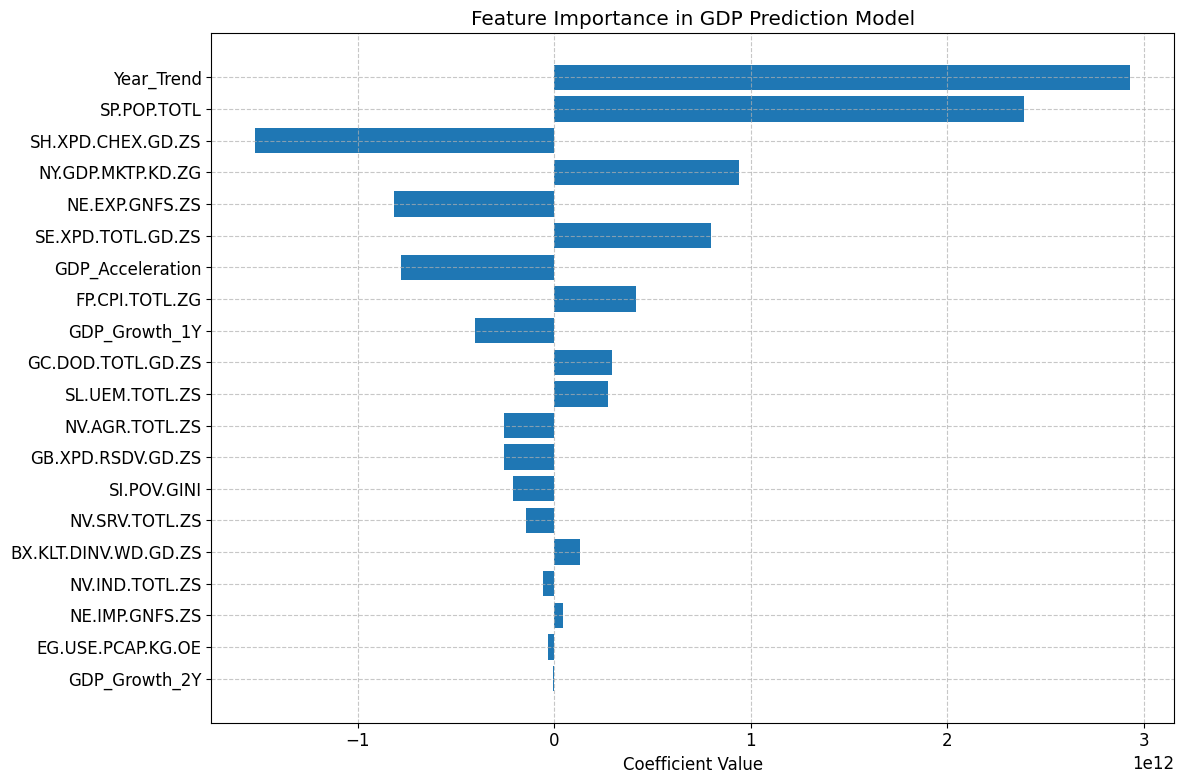

Saved feature importance plot to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_feature_importance.png


In [11]:
# Plot feature importance
plt.figure(figsize=(12, 8))
fig_importance = forecaster.plot_feature_importance()
plt.tight_layout()
plt.show()

# Save the figure
importance_path = RESULTS_DIR / f"{COUNTRY_CODE}_feature_importance.png"
fig_importance.savefig(importance_path, dpi=300, bbox_inches='tight')
print(f"Saved feature importance plot to {importance_path}")

# Save feature importance data
feature_importance.to_csv(RESULTS_DIR / f"{COUNTRY_CODE}_feature_importance.csv")

## 7. Generate Forecasts for Economic Indicators

Before forecasting GDP, we need to forecast the individual economic indicators that drive GDP. Let's generate these forecasts for our chosen time horizon.

In [12]:
# Generate forecast for covariates first
print(f"Forecasting economic indicators for the next {FORECAST_HORIZON} years...")
forecasted_features = forecaster.forecast_features(horizon=FORECAST_HORIZON)
print(f"Forecasted {len(forecasted_features.columns)} economic indicators")

# Display preview of forecasted features
print("\nPreview of forecasted indicators:")
forecasted_features.head()

Forecasting economic indicators for the next 5 years...


KeyError: 'Year_Trend'

Let's visualize the forecasts for the top 5 most important economic indicators:

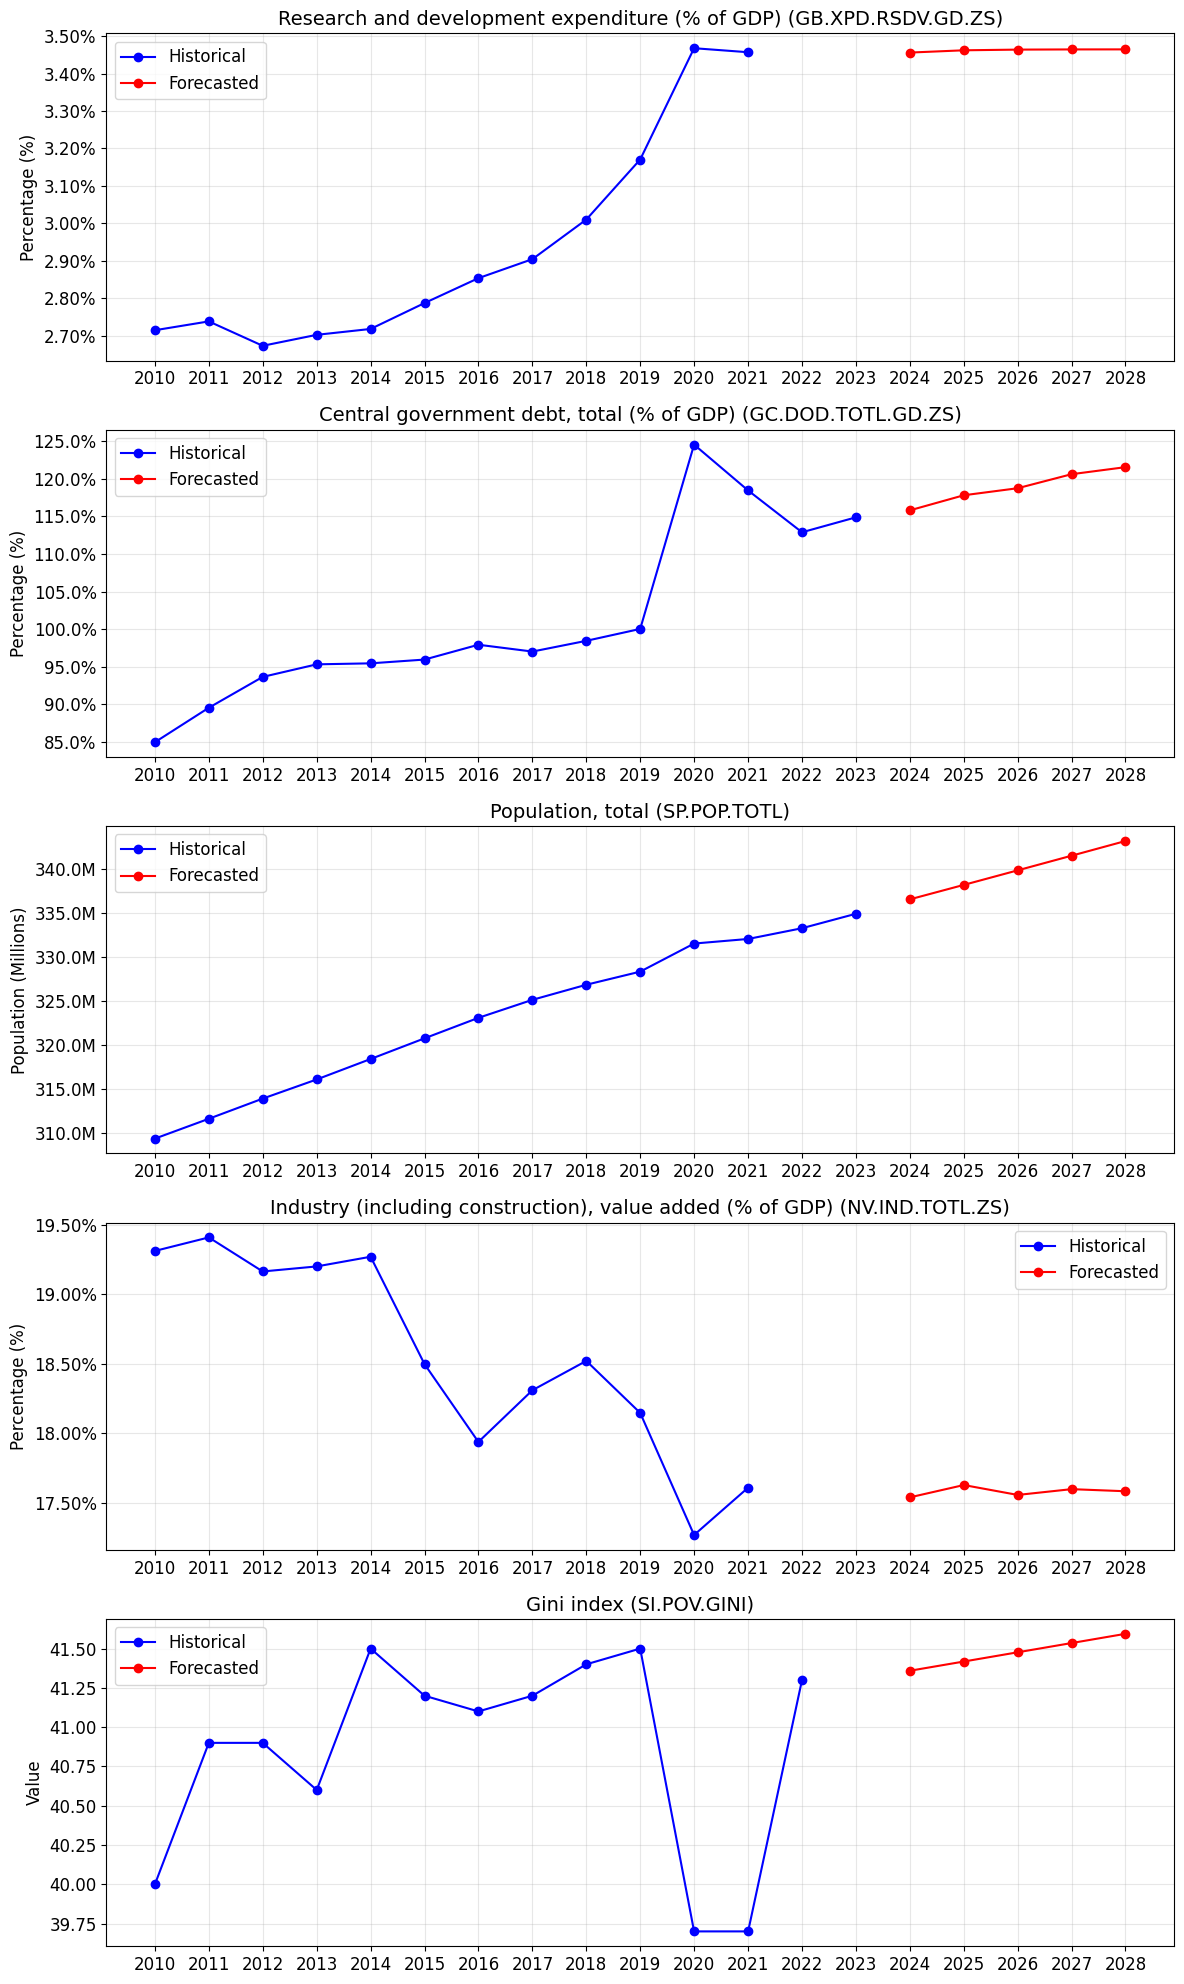

Saved key indicators plot to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_key_indicators_forecast.png


In [13]:
# Plot key forecasted covariates
# Select top 5 important features
top_features = feature_importance.head(5).reset_index(drop=True)
key_indicators = list(top_features['Feature'])

# Create a figure with subplots for each indicator
fig, axes = plt.subplots(len(key_indicators), 1, figsize=(12, 4*len(key_indicators)))

# If only one indicator, axes is not a list
if len(key_indicators) == 1:
    axes = [axes]

# Plot each indicator
for i, feature in enumerate(key_indicators):
    # Get historical data (last 15 years only)
    historical_series = forecaster.historical_data[feature].copy()
    
    # Get last 15 years of data
    current_year = datetime.now().year
    start_year = current_year - 15
    start_date = pd.Timestamp(f"{start_year}-01-01")
    
    # Filter data to the last 15 years
    if len(historical_series) > 15:
        historical_series = historical_series[historical_series.index >= start_date]
    
    # Get forecasted data
    forecasted_series = forecasted_features[feature]
    
    # Plot historical data
    axes[i].plot(historical_series.index, historical_series.values, 'o-', 
                color='blue', label='Historical')
    
    # Plot forecasted data
    axes[i].plot(forecasted_series.index, forecasted_series.values, 'o-', 
                color='red', label='Forecasted')
    
    # Format plot
    feature_description = indicator_descriptions.get(feature, feature)
    axes[i].set_title(f'{feature_description} ({feature})', fontsize=14)
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()
    
    # Format x-axis
    locator = mdates.YearLocator()
    axes[i].xaxis.set_major_locator(locator)
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    # Format y-axis appropriately based on the indicator
    if 'PERCENT' in feature.upper() or 'RATE' in feature.upper() or 'ZS' in feature.upper() or 'ZG' in feature.upper():
        axes[i].yaxis.set_major_formatter(mtick.PercentFormatter())
        axes[i].set_ylabel('Percentage (%)')
    elif 'POP' in feature.upper():
        def millions(x, pos):
            return f'{x/1e6:.1f}M'
        axes[i].yaxis.set_major_formatter(plt.FuncFormatter(millions))
        axes[i].set_ylabel('Population (Millions)')
    else:
        axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()

# Save the figure
indicators_path = RESULTS_DIR / f"{COUNTRY_CODE}_key_indicators_forecast.png"
fig.savefig(indicators_path, dpi=300, bbox_inches='tight')
print(f"Saved key indicators plot to {indicators_path}")

## 8. Generate GDP Forecast

Now that we have forecasted the individual economic indicators, we can use them to generate the GDP forecast.

In [14]:
# Generate GDP forecast
print(f"Forecasting GDP for the next {FORECAST_HORIZON} years...")
gdp_forecast = forecaster.forecast_gdp(horizon=FORECAST_HORIZON)
print("GDP Forecast complete")

# Display the GDP forecast
print("\nGDP Forecast:")
display(gdp_forecast)

Forecasting GDP for the next 5 years...
GDP Forecast complete

GDP Forecast:


,GDP_Forecast,Previous_GDP,Growth_Rate
2024-01-01,2.296665e+13,2.772071e+13,-17.149839
2025-01-01,2.310105e+13,2.296665e+13,0.585183
2026-01-01,2.309842e+13,2.310105e+13,-0.011395
2027-01-01,2.298659e+13,2.309842e+13,-0.484112
2028-01-01,2.295753e+13,2.298659e+13,-0.126423


## 9. Get Official Forecasts for Comparison

Let's compare our GDP forecast with official forecasts from the IMF (if available).

In [15]:
# Get official forecasts
print("Getting official IMF forecasts for comparison...")
try:
    official_forecast = forecaster.get_official_forecasts()
    print("Official forecasts retrieved successfully")
    display(official_forecast)
except Exception as e:
    print(f"Could not get official forecasts: {str(e)}")
    official_forecast = None

2025-03-14 11:53:49,013 - data_collector - INFO - Loading cached IMF forecast data for USA


Getting official IMF forecasts for comparison...
Official forecasts retrieved successfully


,IMF_GDP_Growth
2025-01-01,1.934417
2026-01-01,0.650601
2027-01-01,2.538956
2028-01-01,2.741138


## 10. Visualize GDP Forecast

Let's create visualizations to better understand the GDP forecast.

Creating GDP forecast visualization...


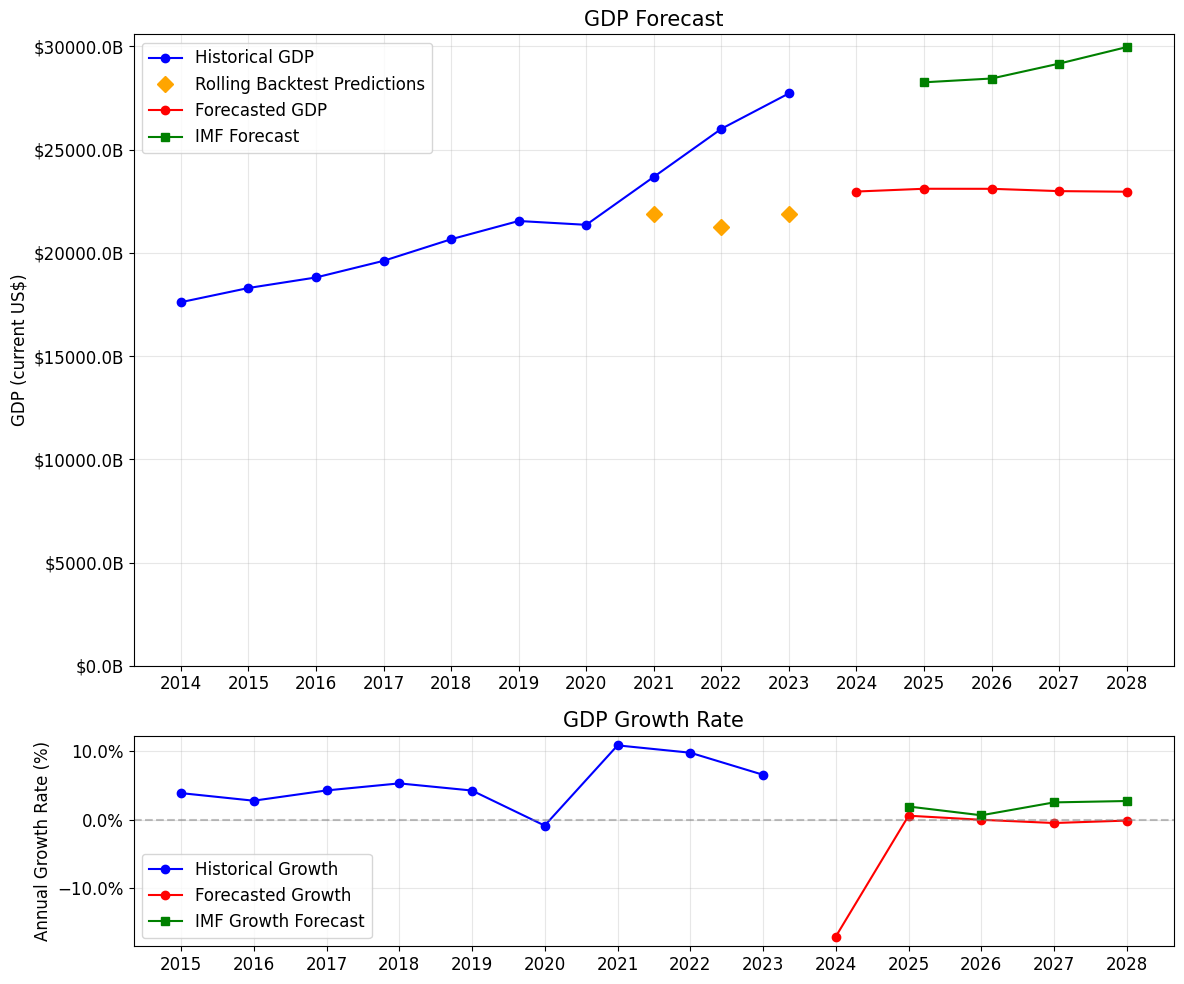

Saved GDP forecast plot to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_gdp_forecast.png


In [16]:
# Create and save GDP and growth plots using plot_forecast method
print("Creating GDP forecast visualization...")

# Use the plot_forecast method with show_history_years=10 and include_backtests=True
fig_forecast = forecaster.plot_forecast(show_history_years=10, include_backtests=True)
plt.show()

# Save the figure
forecast_path = RESULTS_DIR / f"{COUNTRY_CODE}_gdp_forecast.png"
fig_forecast.savefig(forecast_path, dpi=300, bbox_inches='tight')
print(f"Saved GDP forecast plot to {forecast_path}")

Creating GDP growth rate visualization...


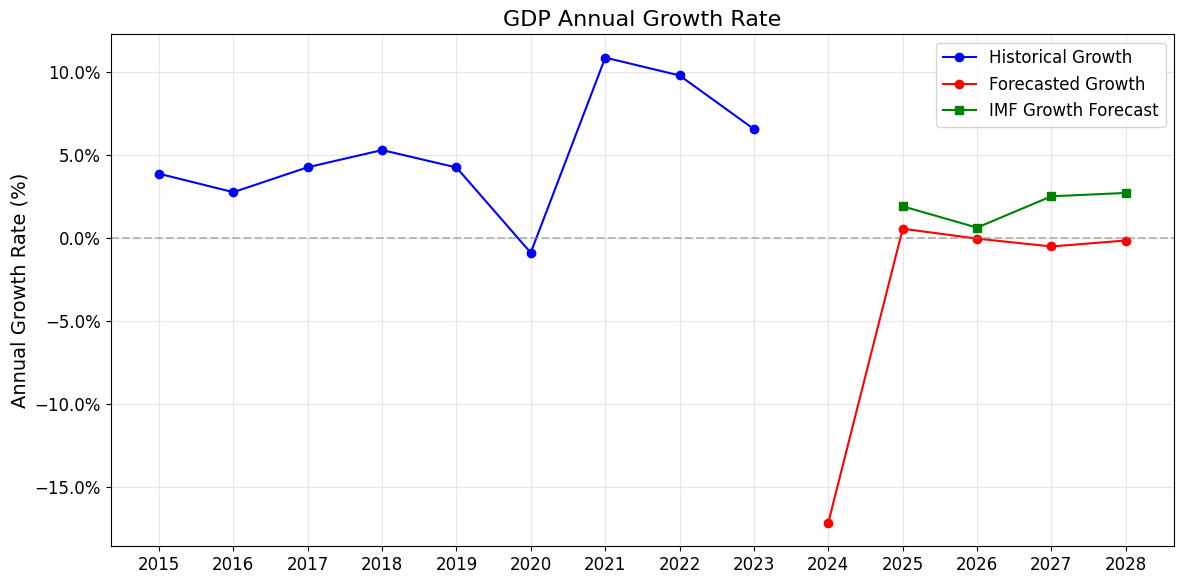

Saved GDP growth plot to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_gdp_growth.png


In [17]:
# Create a separate GDP growth plot
print("Creating GDP growth rate visualization...")

fig_growth, ax = plt.subplots(figsize=(12, 6))

# Get historical GDP data (last 10 years)
historical_gdp = forecaster.historical_data['NY.GDP.MKTP.CD'].copy()
if len(historical_gdp) > 10:
    historical_gdp = historical_gdp.iloc[-10:]

# Calculate historical growth
if len(historical_gdp) > 1:
    historical_growth = historical_gdp.pct_change() * 100
    ax.plot(historical_growth.index, historical_growth.values, 'o-',
            color='blue', label='Historical Growth')

# Add forecasted growth
ax.plot(forecaster.gdp_forecast.index, forecaster.gdp_forecast['Growth_Rate'].values, 'o-',
        color='red', label='Forecasted Growth')

# Add IMF growth if available
if forecaster.official_forecast is not None and 'IMF_GDP_Growth' in forecaster.official_forecast.columns:
    ax.plot(forecaster.official_forecast.index,
            forecaster.official_forecast['IMF_GDP_Growth'].values, 's-',
            color='green', label='IMF Growth Forecast')

# Format plot
ax.set_title('GDP Annual Growth Rate', fontsize=16)
ax.set_ylabel('Annual Growth Rate (%)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)

# Format x-axis to show only years
locator = mdates.YearLocator()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Format y-axis to show percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Add horizontal line at 0%
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Save the growth rate plot
growth_path = RESULTS_DIR / f"{COUNTRY_CODE}_gdp_growth.png"
fig_growth.savefig(growth_path, dpi=300, bbox_inches='tight')
print(f"Saved GDP growth plot to {growth_path}")

## 11. Print Detailed Forecast Summary

Let's generate a comprehensive summary of the GDP forecast.

In [18]:
# Print detailed forecast summary
print("\nDetailed Forecast Summary:")
forecaster.print_forecast_summary()


Detailed Forecast Summary:

GDP Forecast Summary for USA
+------+--------------+-------------+------------+------------+
| Year | GDP Forecast | Growth Rate | IMF Growth | Difference |
+------+--------------+-------------+------------+------------+
| 2024 |  $22966.65B  |   -17.15%   |    nan%    |    nan%    |
| 2025 |  $23101.05B  |    0.59%    |   1.93%    |   -1.35%   |
| 2026 |  $23098.42B  |   -0.01%    |   0.65%    |   -0.66%   |
| 2027 |  $22986.59B  |   -0.48%    |   2.54%    |   -3.02%   |
| 2028 |  $22957.53B  |   -0.13%    |   2.74%    |   -2.87%   |
+------+--------------+-------------+------------+------------+

Key Economic Indicators (Forecasted):
--------------------------------------------------------------------------------
2024: NY_GDP_MKTP_KD_ZG: 2.88%, SP_POP_TOTL: 336.56M, SI_POV_GINI: 41.4, NE_EXP_GNFS_ZS: 10.65%, NE_IMP_GNFS_ZS: 13.85%, BX_KLT_DINV_WD_GD_ZS: 1.29%, GC_DOD_TOTL_GD_ZS: 115.81%, SL_UEM_TOTL_ZS: 4.30%, FP_CPI_TOTL_ZG: 1.64%, GB_XPD_RSDV_GD_ZS: 3.4

## 12. Export Results

Finally, let's export all the forecast data and generate a comprehensive report.

In [19]:
# Export all forecast data
print(f"Exporting all forecast data to {RESULTS_DIR}...")
forecaster.export_results(str(RESULTS_DIR))
print("Data export complete")

2025-03-14 11:53:50,023 - gdp_forecaster - INFO - GDP forecast exported to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_gdp_forecast.csv
2025-03-14 11:53:50,025 - gdp_forecaster - INFO - Feature forecasts exported to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_features_forecast.csv
2025-03-14 11:53:50,029 - gdp_forecaster - INFO - Forecast comparison exported to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_forecast_comparison.csv
2025-03-14 11:53:50,031 - gdp_forecaster - INFO - Historical data exported to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_historical_data.csv


Exporting all forecast data to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA...


2025-03-14 11:53:50,468 - gdp_forecaster - INFO - Forecast plot saved to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_gdp_forecast_plot.png
2025-03-14 11:53:50,469 - gdp_forecaster - INFO - Rolling backtest results exported to /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_rolling_backtest_results.csv


Data export complete


In [20]:
# Generate HTML report
print("Generating comprehensive HTML report...")

# Include backtest metrics if available
if backtest_metrics:
    metrics.update({'Backtest_MAPE': backtest_metrics['MAPE'], 
                    'Backtest_RMSE': backtest_metrics['RMSE']})

try:
    report_path = generate_report(
        country_code=COUNTRY_CODE,
        results_dir=RESULTS_DIR,
        metrics=metrics,
        gdp_forecast=gdp_forecast,
        feature_importance=feature_importance,
        forecast_horizon=FORECAST_HORIZON,
        backtest_years=BACKTEST_YEARS,
        backtest_results=forecaster.backtest_results if RUN_ROLLING_BACKTESTS else None
    )
    print(f"Generated comprehensive report: {report_path}")
except Exception as e:
    print(f"Could not generate report: {str(e)}")

Generating comprehensive HTML report...
Generated comprehensive report: /Users/ignasipascual/Documents/GitHub/GDP-Forecaster/results/USA/USA_forecast_report.html


## Conclusion

We've successfully completed the entire GDP forecasting process for {COUNTRY_CODE}. The forecast and all related data have been saved to the results directory.

### Key Results

- **Forecast Period**: {FORECAST_HORIZON} years
- **Expected Accuracy** (based on backtests): MAPE of approximately {backtest_metrics['MAPE']:.2f}% if available
- **Key Drivers**: The top economic indicators that most strongly influence GDP have been identified through feature importance analysis
- **Forecast Outputs**: GDP values and growth rates have been predicted for the next {FORECAST_HORIZON} years
- **Comparison**: Our forecasts have been compared with official IMF projections (when available)

### Files Generated

- GDP forecast data (CSV)
- Economic indicator forecasts (CSV)
- Feature importance rankings (CSV)
- GDP forecast visualization (PNG)
- GDP growth rate visualization (PNG)
- Key economic indicators visualization (PNG)
- Feature importance visualization (PNG)
- Comprehensive HTML report
- Detailed log file

### Next Steps

1. **Examine the HTML report** for a comprehensive overview of the forecast
2. **Review feature importance** to understand which economic factors are driving GDP in this country
3. **Compare with expert forecasts** from organizations like the IMF, World Bank, or country-specific sources
4. **Consider sensitivity analysis** for key variables (how would changes in top drivers affect the forecast?)
5. **Repeat the analysis for other countries** to enable cross-country comparisons

This notebook can be modified to analyze different countries, timeframes, or economic scenarios.